In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [6]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

RANDOM_SEED = 42

In [7]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data = FeaturesManager.build_features(seasons_year, season_type)

# We take the absolute value, for symmetry reasons
features_data['Shot angle'] = features_data['Shot angle'].abs()
features_data.sample(10)

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Shooter ID,Goalie,Goalie ID,...,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Num players With,Num players Against,Elapsed time since Power Play
72156,2015021202,211,3,Boston Bruins (BOS),Goal,Tip-In,Loui Eriksson,8470626,Jimmy Howard,8470657,...,2445,14.703552,0.0,0.000000,16.415027,0.130178,0.089630,5.0,5.0,0.0
316,2015020006,4,1,Ottawa Senators (OTT),Goal,Wrist Shot,Kyle Turris,8474068,Robin Lehner,8475215,...,30,0.000000,0.0,0.000000,1.996942,0.111628,0.094994,5.0,5.0,0.0
105589,2016020524,73,1,Calgary Flames (CGY),Shot,Wrist Shot,Deryk Engelland,8468674,Calvin Pickard,8475717,...,1088,46.507436,0.0,0.000000,6.210430,0.042254,0.077922,5.0,5.0,0.0
190080,2017020751,49,1,Chicago Blackhawks (CHI),Shot,Slap Shot,Duncan Keith,8470281,Jimmy Howard,8470657,...,473,-42.878904,0.0,0.000000,10.354816,NaN,NaN,NaN,NaN,NaN
96455,2016020373,135,2,Nashville Predators (NSH),Goal,Tip-In,Calle Jarnkrok,8475714,Steve Mason,8473461,...,1397,-62.850318,0.0,0.000000,6.666667,0.128000,0.082397,5.0,5.0,0.0
196543,2017020851,288,3,Edmonton Oilers (EDM),Shot,Snap Shot,Patrick Maroon,8474034,Aaron Dell,8477180,...,3387,85.710847,0.0,0.000000,12.020815,NaN,NaN,NaN,NaN,NaN
124295,2016020832,184,2,Boston Bruins (BOS),Shot,Snap Shot,Patrice Bergeron,8470638,Carey Price,8471679,...,1785,26.565051,1.0,51.340192,2.667245,0.113475,0.065753,5.0,5.0,0.0
220255,2017021234,31,1,Nashville Predators (NSH),Shot,Slap Shot,Eeli Tolvanen,8480009,Roberto Luongo,8466141,...,315,75.963757,1.0,30.963757,9.486833,NaN,NaN,NaN,NaN,NaN
162147,2017020301,100,1,Minnesota Wild (MIN),Shot,Wrist Shot,Jason Zucker,8475722,Braden Holtby,8474651,...,1184,-47.726311,0.0,0.000000,0.806226,NaN,NaN,NaN,NaN,NaN
214586,2017021141,176,2,Detroit Red Wings (DET),Shot,Snap Shot,Anthony Mantha,8477511,Philipp Grubauer,8475831,...,1988,47.726311,0.0,0.000000,7.601170,NaN,NaN,NaN,NaN,NaN


In [8]:
distance_data = features_data[['Shot distance', 'Is Goal']].dropna()
X = distance_data[['Shot distance']]
y = distance_data['Is Goal']

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
print(X_train.shape)
print(y_train.shape)

(240350, 1)
(240350,)


In [10]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [11]:
accuracy = clf.score(X_valid, y_valid)
print(f'Accuracy on validation set = {np.around(100.*accuracy, 2)}%')

Accuracy on validation set = 90.62%


0.906154307016376
Dumb Accuracy on validation set = 90.62%


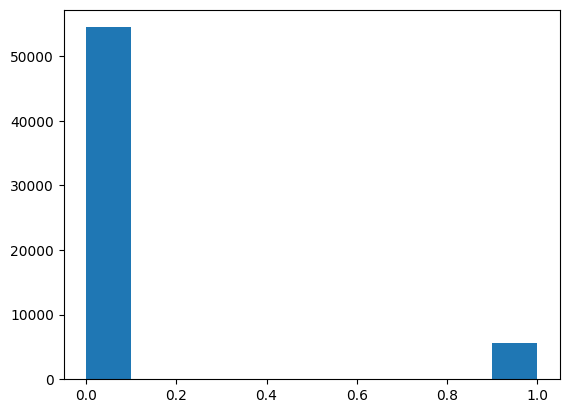

In [12]:
# Accuracy is not the right metric to use, as the classes are unbalanced
num_goals = (y_valid==1).sum()
num_no_goals = (y_valid==0).sum()
print(num_no_goals / (num_no_goals+num_goals))
plt.hist(y_valid);

# A dumb model that predicts 0 (no goals) all the time reach the same level of performance
def dumb_model(X, y):
    pred = np.zeros_like(X)
    return (y == pred.ravel()).mean()


dumb_accuracy = dumb_model(X_valid, y_valid)
print(f'Dumb Accuracy on validation set = {np.around(100.*dumb_accuracy, 2)}%')

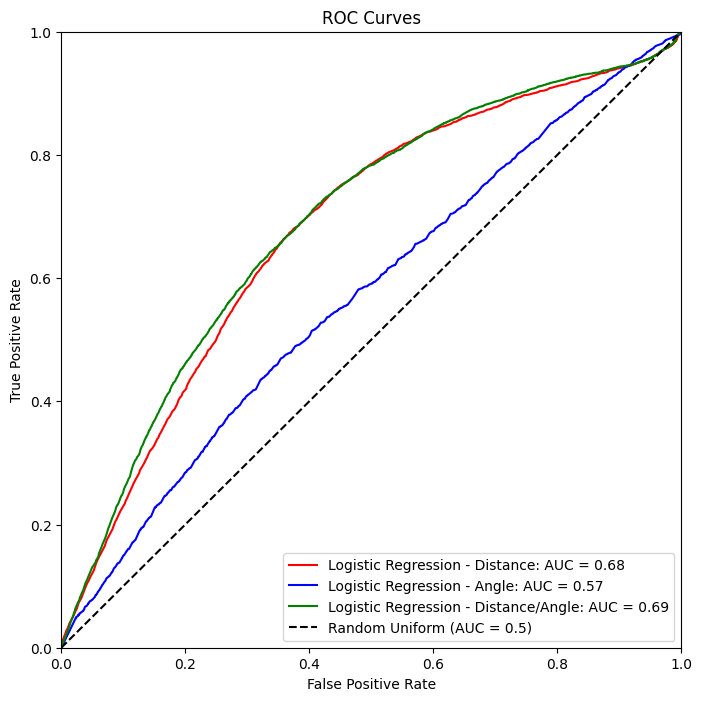

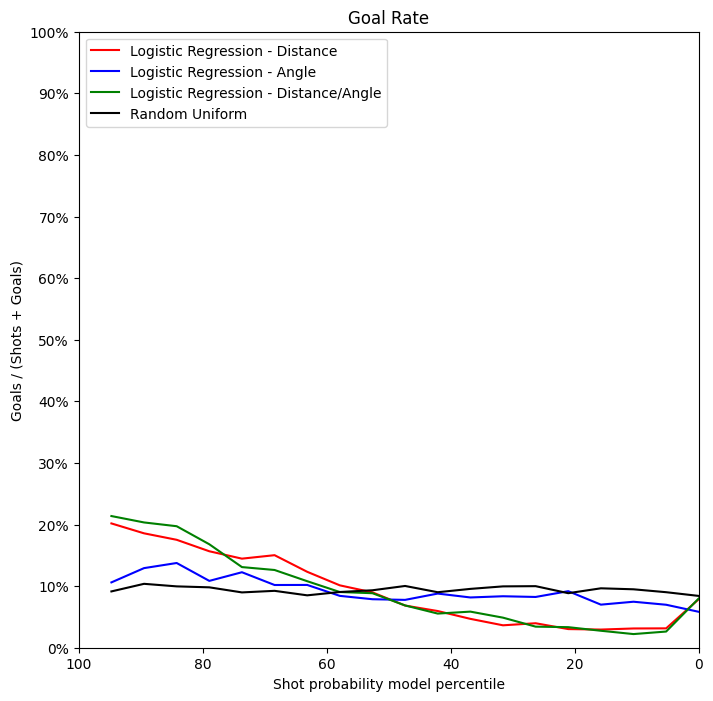

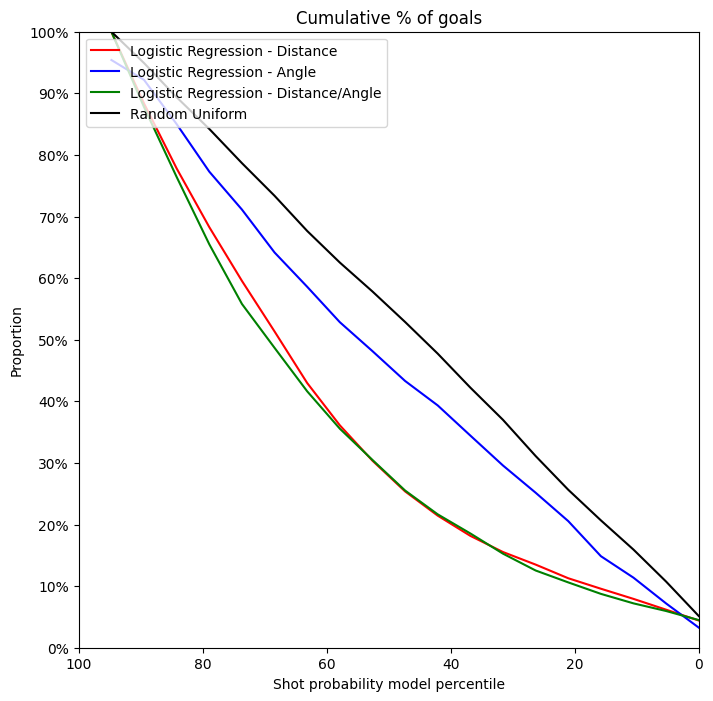

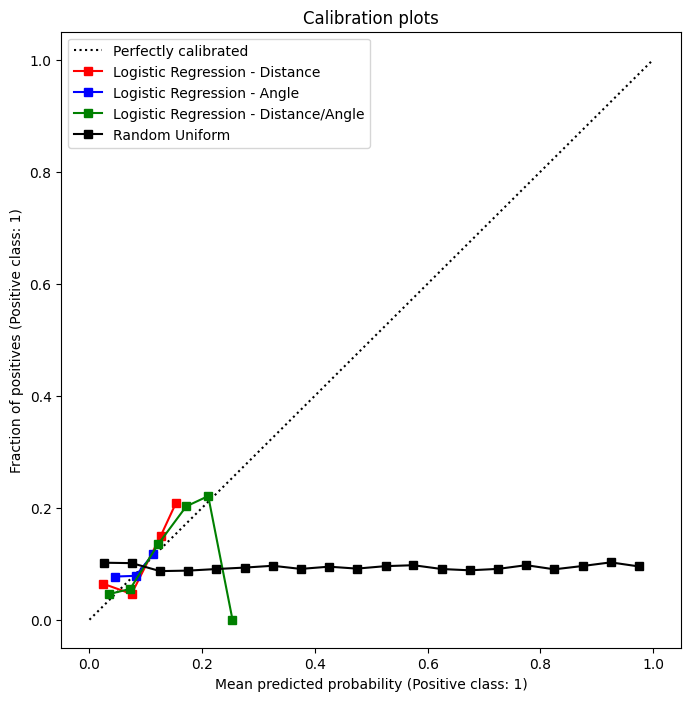

In [13]:
distance_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()
X = distance_data[['Shot distance', 'Shot angle']].to_numpy().reshape(-1, 2)
y = distance_data['Is Goal'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)


# Logistic Regression - Distance only
X_distance_train, X_distance_valid = X_train[:,0].reshape(-1, 1), X_valid[:,0].reshape(-1, 1)
clf_distance = LogisticRegression(random_state=0).fit(X_distance_train, y_train)
from sklearn.metrics import classification_report

print(classification_report(y_valid, clf_distance.predict(X_distance_valid))


# Logistic Regression - Angle only
X_angle_train, X_angle_valid = X_train[:,1].reshape(-1, 1), X_valid[:,1].reshape(-1, 1)
clf_angle = LogisticRegression(random_state=0).fit(X_angle_train, y_train)

# Logistic Regression - Distance and Angle
X_distance_angle_train, X_distance_angle_valid = X_train, X_valid
clf_distance_angle = LogisticRegression(random_state=0).fit(X_distance_angle_train, y_train)

classifiers = [(clf_distance, 'Logistic Regression - Distance', X_distance_valid, y_valid),
               (clf_angle, 'Logistic Regression - Angle', X_angle_valid, y_valid),
               (clf_distance_angle, 'Logistic Regression - Distance/Angle', X_distance_angle_valid, y_valid) ]


VizManager.plot_all_figures(classifiers, add_random=True)
